# cNMF in `cellarium-ml`

Yang Xu

Stephen Fleming

2024.11.20

The `cellarium-ml` project:

https://github.com/cellarium-ai/cellarium-ml

The specific implementation of cNMF we are actively working on:

https://github.com/cellarium-ai/cellarium-ml/pull/196

## Overview

`cellarium-ml` implements a variety of algorithms in a way that is scalable to hundreds of millions of cells and beyond. This notebook provides a demo run of Cellarium's implementation of consensus NMF (cNMF). The specific algorithm for NMF is based on "Online learning for matrix factorization and sparse coding" by Mairal, Bach, Ponce, and Sapiro (JMLR 2010).

__Pre-processing__ which can also be done using `cellarium-ml` but is not part of this notebook.

0. Compute highly-variable genes.

__Running cNMF happens in four stages:__

1. The initial fit on selected highly-variable genes.

    This amounts to creating a YAML file and then running a single command from the command line:
    ```bash
    cellarium-ml nmf fit --config config.yaml
    ```

2. Interactive plotting in the notebook to help determine optimal `k`, `density_threshold`, and `local_neighborhood_size`.

    Uses functions that are currently called `update_consensusD()` and `calculate_rec_error()` in this notebook, along with some plotting.

3. Computing per-cell factor loadings.

    Uses the function currently called `get_embedding()` in this notebook.

4. Re-computing the `k` factor definitions using all genes (not just highly-variable genes).

    Not yet part of this notebook.

NOTE: You will need to use the `cnmf-yx-streamline` branch of `cellarium-ml` on github.

In [1]:
from cellarium.ml.core import CellariumModule
from cellarium.ml.utilities.data import AnnDataField, densify
from cellarium.ml.data import (
    DistributedAnnDataCollection,
    IterableDistributedAnnDataCollectionDataset,
)
from cellarium.ml.models.nmf import calculate_rec_error, get_embedding, update_consensusD

import os
from string import Template

import torch
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/Users/sfleming/miniconda3/envs/cellarium/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
sc.set_figure_params(scanpy=True, dpi=75, dpi_save=75, vector_friendly=True)

## Parameters

In [2]:
# choose which values of k to use

k_values: list[int] = list(range(10, 40))  # this thing needs to be a python list

# choose how many repeats of NMF to run to create a "consensus"

num_repeats: int = 100

## Data

This demo uses a human heart dataset which is hosted in a google bucket. We will first download the dataset to the machine where this notebook is running, and then we will run cNMF.

We require 2 files:

- The dataset in h5ad format. In this case the entire dataset is a single h5ad file, but `cellarium-ml` can use an arbitrary number of h5ad files.
- The highly variable genes in CSV format.

In [3]:
# change these values to run on a different dataset:

# define file paths

dataset_h5ad = "gs://yx-data/Strati_pbmc_rna.h5ad"
highly_variable_genes_csv = "gs://yx-data/Strati_pbmc_rna_2000hvg.csv"

# define working directory

working_dir = "./tmp"

In [4]:
!mkdir -p $working_dir

In [5]:
# localize data

local_h5ad = os.path.join(working_dir, "data.h5ad")
local_hvg_csv = os.path.join(working_dir, "hvg.csv")

!gsutil cp $dataset_h5ad $local_h5ad
!gsutil cp $highly_variable_genes_csv $local_hvg_csv

Copying gs://yx-data/Strati_pbmc_rna.h5ad...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

| [1 files][662.8 MiB/662.8 MiB]   48.8 MiB/s                                   
Operation completed over 1 objects/662.8 MiB.                                    
Copying gs://yx-data/Strati_pbmc_rna_2000hvg.csv...
/ [1 files][ 31.3 KiB/ 31.3 KiB]                                                
Operation completed over 1 objects/31.3 KiB.                                     


## Config file

This part contains a hack to make things seem simpler: we provide a template config.yaml file here and we modify that file according to the inputs above.

In reality, you would probably create the config.yaml file directly without using the little helpers in this section of the notebook. But this helper makes things smoother for this demo.

In [6]:
# define the path to the config file

config_file_template = "../examples/cli_workflow/nmf_config_template.yaml"  # if you have cloned the repository, it's here

In [7]:
adata = sc.read_h5ad(local_h5ad)
dataset_ncells = adata.n_obs
n_genes_total = adata.n_vars

In [8]:
# modification of the yaml config file to point to this data

local_config_yaml = os.path.join(working_dir, "config.yaml")

with open(config_file_template, "r") as file:
    yaml_text = file.read()

substitutions = {
    "highly_variable_genes_csv": os.path.abspath(local_hvg_csv),
    "dataset_h5ad": os.path.abspath(local_h5ad),
    "dataset_ncells": dataset_ncells,
    "k_range": k_values,
    "num_repeats": num_repeats,
    "n_genes_total": n_genes_total,
}

template = Template(yaml_text)
customized_yaml = template.substitute(substitutions)

# write the customized YAML to a local file in the working directory
with open(local_config_yaml, "w") as file:
    file.write(customized_yaml)

print(f"Config YAML written to: {local_config_yaml}")

Config YAML written to: ./tmp/config.yaml


In [9]:
# take a look at the config file we end up with: again you could skip the above and write this file manually

!cat $local_config_yaml

# lightning.pytorch==2.4.0
seed_everything: true
trainer:
  num_nodes: 1
  max_epochs: 1
model:
  cpu_transforms:
  - class_path: cellarium.ml.transforms.Filter
    init_args:
      filter_list:
        !FileLoader
        file_path: /Users/sfleming/Documents/Github/cellarium-ml/notebooks/tmp/hvg.csv
        loader_fn: pandas.read_csv
        attr: "ensembl_id"
        convert_fn: pandas.Series.to_list
  transforms: null
  model:
    class_path: cellarium.ml.models.NonNegativeMatrixFactorization
    init_args:
      var_names_g: null
      var_names_hvg:
        !FileLoader
        file_path: /Users/sfleming/Documents/Github/cellarium-ml/notebooks/tmp/hvg.csv
        loader_fn: pandas.read_csv
        attr: "ensembl_id"
        convert_fn: pandas.Series.to_list
      k_range: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
      r: 100
      full_g: 26832
      density_threshold: 0.25
      local_neighborhood_size

## Run cNMF

In [10]:
!cellarium-ml nmf fit -c $local_config_yaml

Seed set to 0
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type              | Params | Mode 
-------------------------------------------------------
0 | pipeline | CellariumPipeline | 1      | train
-------------------------------------------------------
1         Trainable params
0         Non-trainable params
1         Total params
0.000     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
Epoch 0: 100%|███████████████████████| 91/91 [4:22:15<00:00,  0.01it/s, v_num=9]


## Load the trained NMF model

and the dataset

In [11]:
# helper function

def get_cellarium_dataset_from_h5ad(
    h5ad: str, 
    batch_size: int = 1024, 
    shard_size: int | None = None, 
    shuffle: bool = False, 
    drop_last_indices: bool = False,
) -> IterableDistributedAnnDataCollectionDataset:
    """
    Get IterableDistributedAnnDataCollectionDataset from an h5ad file specifier.

    Args:
        h5ad: h5ad file, allowing brace notation for several files.
        batch_size: Batch size.
        shard_size: Shard size.
        shuffle: Whether to shuffle the dataset.
        drop_last_indices: Whether to drop the last incomplete batch.

    Returns:
        IterableDistributedAnnDataCollectionDataset.
    """
    dadc = DistributedAnnDataCollection(
        h5ad,
        shard_size=shard_size,
        max_cache_size=1,
    )

    dataset = IterableDistributedAnnDataCollectionDataset(
        dadc,
        batch_keys={
            "x_ng": AnnDataField(attr="X", convert_fn=densify),
            "var_names_g": AnnDataField(attr="var_names"),
            "obs_names_n": AnnDataField(attr="obs_names"),
        },
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last_indices=drop_last_indices,
    )
    return dataset

In [12]:
# load trained module

ckpt_file = "NMF.ckpt"  # currently this is hard-coded, but we will change this

module = CellariumModule.load_from_checkpoint(ckpt_file)
module.eval()
module

CellariumModule(pipeline = CellariumPipeline(
  (0): Filter(filter_list=['ENSG00000186891' 'ENSG00000142609' 'ENSG00000233542' ...
   'ENSG00000275063' 'ENSG00000277836' 'ENSG00000276017'])
  (1): NonNegativeMatrixFactorization()
))

In [13]:
# get a dataset object in the necessary cellarium-ml format

dataset = get_cellarium_dataset_from_h5ad(
    os.path.abspath(local_h5ad), 
    shard_size=adata.n_obs,
    shuffle=False, 
    drop_last_indices=False,
)
dataset

### Compute consensus factors

as well as "stability" scores, a.k.a. silhouette scores

In [31]:
# calculate consensus D for all Ks

# change these thresholds if desired
density_threshold = 0.25
local_neighborhood_size = 0.3

consensus_stat = update_consensusD(
    module.pipeline,
    density_threshold=density_threshold, 
    local_neighborhood_size=local_neighborhood_size,
)

silhouette score of k=10: 0.7966
silhouette score of k=11: 0.8056
silhouette score of k=12: 0.8937
silhouette score of k=13: 0.8697
silhouette score of k=14: 0.9073
silhouette score of k=15: 0.769
silhouette score of k=16: 0.8292
silhouette score of k=17: 0.8258
silhouette score of k=18: 0.8691
silhouette score of k=19: 0.7894
silhouette score of k=20: 0.7913
silhouette score of k=21: 0.8276
silhouette score of k=22: 0.7523
silhouette score of k=23: 0.8383
silhouette score of k=24: 0.7998
silhouette score of k=25: 0.7911
silhouette score of k=26: 0.8108
silhouette score of k=27: 0.8066
silhouette score of k=28: 0.824
silhouette score of k=29: 0.8684
silhouette score of k=30: 0.783
silhouette score of k=31: 0.7978
silhouette score of k=32: 0.7693
silhouette score of k=33: 0.8485
silhouette score of k=34: 0.852
silhouette score of k=35: 0.8543
silhouette score of k=36: 0.8379
silhouette score of k=37: 0.7811
silhouette score of k=38: 0.8495
silhouette score of k=39: 0.8415


### Create clustermap plots

In [33]:
# (optional) get gene loadings (of highly variable genes) for a specific k

def get_gene_loadings_for_k(k: int, model=module.pipeline[-1]) -> torch.Tensor:
    D_kg = getattr(model, f"D_{k}_kg")
    D_kg = D_kg.detach().cpu()
    return D_kg


D_kg = get_gene_loadings_for_k(10)
print(D_kg.shape)
D_kg

torch.Size([10, 2000])


tensor([[0.0000e+00, 2.8109e-06, 1.0367e-06,  ..., 2.2215e-04, 1.9529e-05,
         0.0000e+00],
        [0.0000e+00, 4.9048e-06, 4.7315e-06,  ..., 2.1087e-04, 1.9575e-05,
         0.0000e+00],
        [1.7726e-03, 1.6546e-05, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 2.0228e-05, 1.5023e-05,  ..., 0.0000e+00, 1.5054e-05,
         6.7405e-06],
        [0.0000e+00, 2.2086e-05, 1.2448e-05,  ..., 0.0000e+00, 7.3592e-06,
         1.2794e-05],
        [7.7053e-03, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])

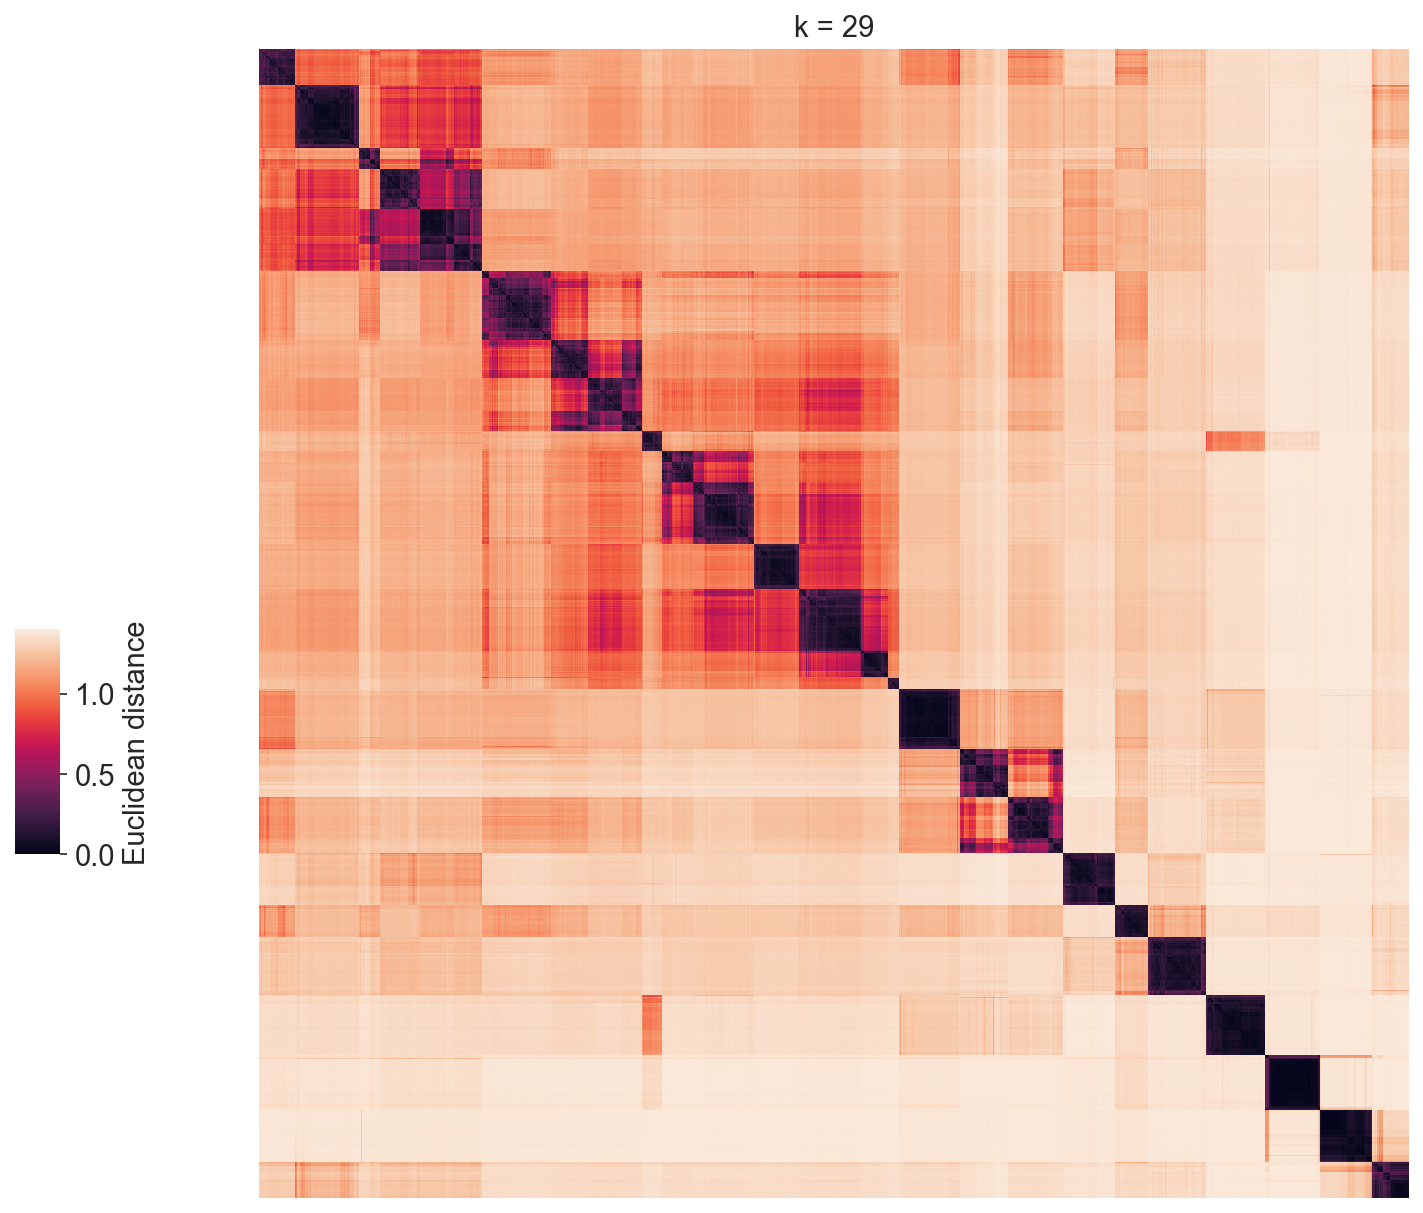

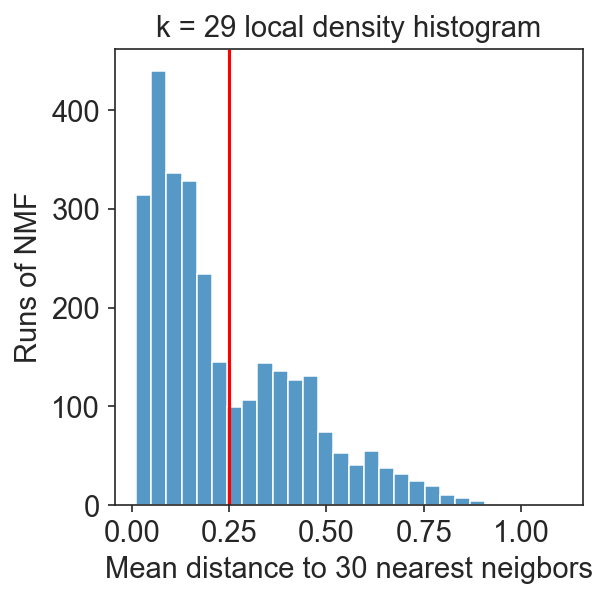

In [ ]:
for k in k_values:
    cg = sns.clustermap(consensus_stat[k]['topk_euc_dist'].cpu().numpy(), 
                   row_cluster=True, col_cluster=True, cbar_pos=(0.05, 0.25, 0.03, 0.15),
                   xticklabels=False, yticklabels=False, rasterized=True)
    cg.ax_row_dendrogram.set_visible(False)
    cg.ax_col_dendrogram.set_visible(False)
    # cg.cax.set_visible(False)
    cg.cax.set_ylabel('Euclidean distance')
    cg.ax_heatmap.set_title(f"k = {k}")
    plt.show()
    
    sns.histplot(consensus_stat[k]['local_neigh_dist'].cpu().numpy())
    ymax = plt.gca().get_ylim()[1]
    plt.vlines(density_threshold, ymin=0, ymax=ymax, color='Red')
    plt.xlabel(f'Mean distance to {int(num_repeats * local_neighborhood_size)} nearest neigbors')
    plt.ylabel('Runs of NMF')
    plt.title(f"k = {k} local density histogram")
    plt.ylim(0, ymax)
    
    plt.show()

### Compute reconstruction error at each k

In [37]:
# we need to calculate the reconstruction error: this takes time

rec_errors = calculate_rec_error(dataset, module.pipeline)

100%|██████████| 91/91 [1:02:29<00:00, 41.21s/it]


### Create the k-selection plot

In [38]:
silhouette_scores = {}
for k in k_values:
    silhouette_scores[k] = consensus_stat[k]['stability']
eval_metrics = pd.DataFrame.from_dict(silhouette_scores, orient='index')
eval_metrics.columns = ['stability']
eval_metrics['rec_error'] = rec_errors

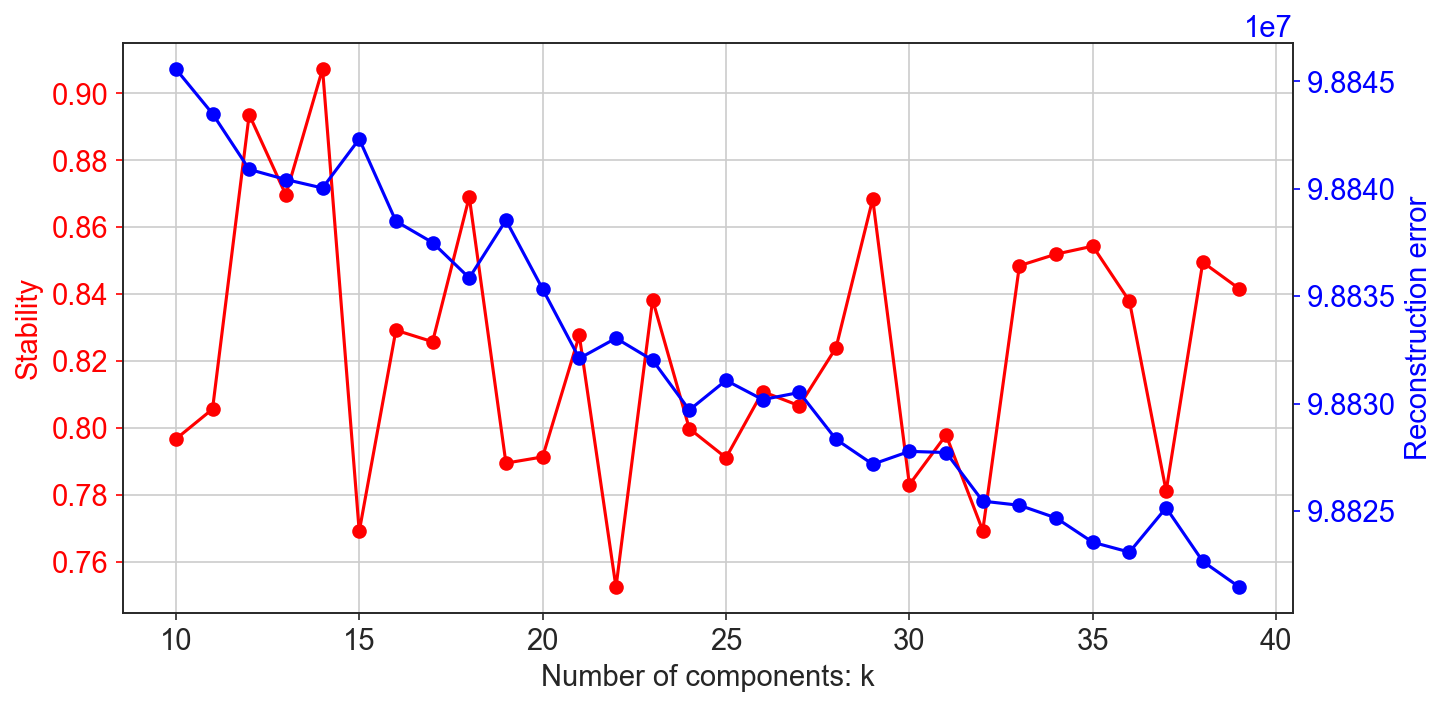

In [ ]:
# plot stability and reconstruction error

plt.figure(figsize=(10, 5))
plt.plot(eval_metrics.index, eval_metrics['stability'], 'o-', color='r')
plt.grid(True)
plt.ylabel('Stability', color='r')
plt.xlabel('Number of components: k')
plt.gca().tick_params(axis='y', colors='r')
plt.twinx()
plt.plot(eval_metrics.index, eval_metrics['rec_error'], 'o-', color='b')
plt.ylabel('Reconstruction error', color='b')
plt.gca().tick_params(axis='y', colors='b')
plt.show()

### Compute per-cell loadings

The loadings of each factor, computed for each cell.

In [43]:
# get per-cell factor loadings using the best k: this takes time

best_k = 29
obsm_key_added = 'X_nmf'
df = get_embedding(dataset, module.pipeline, k=best_k)

100%|██████████| 91/91 [01:57<00:00,  1.29s/it]


In [44]:
# add this information to the anndata object

adata.obsm['X_nmf'] = df.loc[adata.obs_names].values
adata.obsm['X_nmf'].shape

(92676, 29)

In [45]:
# see whether the loadings sum to 1 (nearly)

adata.obsm['X_nmf'].sum(axis=1)

array([1.        , 1.        , 0.99999994, ..., 1.        , 0.9999999 ,
       1.0000001 ], dtype=float32)

### UMAP based on cNMF factor loadings

In [46]:
# compute UMAP

sc.pp.neighbors(adata, use_rep='X_nmf', n_neighbors=15, metric='cosine')
sc.tl.umap(adata)

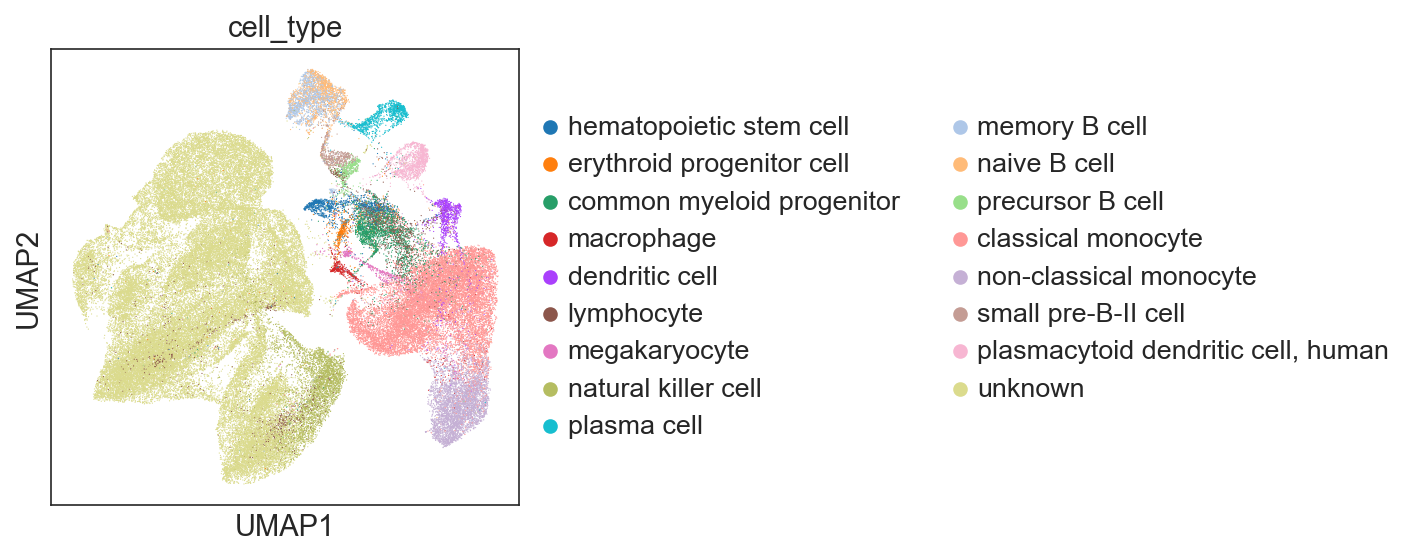

In [ ]:
sc.pl.embedding(adata, basis='umap', color=['cell_type', 'disease_setting', 'therapy', 'analysis_group', 'sex', 'donor_id'], ncols=1)